In [1]:
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import numpy as np
import sys
%matplotlib inline

In [2]:
def time_in_seconds(val):
    if "-" in val:
        fields = val.split("-")
        sec=0.0
        for i in fields:
            if "s" in i: sec += float(i.strip("s"))
            if "m" in i: sec += 60 * float(i.strip("m"))
            if "h" in i: sec += 3600 * float(i.strip("h"))
        return sec
    else:
        return float(val.strip("s"))

In [3]:
def parse_report(file_name):
    buffer = []
    resources_dict = {
        "MPI Cores": "mpi", "Threads per core": "thrs", "Threads total": "thr_tot", 
        "Nodes Computing": "nodes", "Nodes IO": "nodes_io", "MPI tasks / GPU": "mpi/gpu",
    }
    resources = {}
    timing = {}
    log = False
    with open(file_name, 'r') as report:
        for line in report:
            if line == "\n": log = False
            if log: 
                buffer.append(line.strip())
            else:
                for key, val in resources_dict.items():
                    if key in line: resources[val] = int(line.strip().split(":")[1])
                if "Time-Profile" in line:
                    timing["Time-Profile"] = time_in_seconds(line.strip().split(":")[1])

            if "Clock:" in line: log = True

    for line in buffer:
        fields = line.split(":")
        timing[fields[0].strip()] = time_in_seconds(fields[1].strip().split()[0])
    return resources, timing

In [4]:
def build_dataframe(x_axis='mpi', factor=1, rename_cols={}):
    r_files = glob("r-*")

    data = {}
    for report in r_files:
        resources, timing = parse_report(report)
        for key, val in resources.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
        for key, val in timing.items():
            if key in data:
                data[key].append(val)
            else:
                data[key] = [val,]
    
    scaling = pd.DataFrame(data)
    if rename_cols: 
        scaling.rename(columns=rename_cols, inplace=True)
    else:
        scaling.rename(columns={'Xo (procedure)': 'Xo', 'X (procedure)': 'X'}, inplace=True)
    scaling.sort_values(by=[x_axis], inplace=True)
    if 'mpi/gpu' in scaling: scaling['gpu'] = pd.Series(scaling['mpi'] / scaling['mpi/gpu'], dtype=np.int64)
    scaling['ideal'] = scaling[x_axis] / factor
    scaling['speedup'] = scaling[scaling[x_axis]>=factor]['Time-Profile'].max() / scaling['Time-Profile']
    scaling['efficiency'] = scaling.speedup / scaling.ideal * 100
    scaling['Self energy'] = scaling['HF'] + scaling['GW(ppa)']
    scaling['Other'] = scaling['Time-Profile'] - scaling['Dipoles'] - scaling['Xo'] - scaling['X'] - scaling['Self energy']
    scaling['node_h'] = scaling['nodes'] * scaling['Time-Profile'] / 3600
    return scaling

In [5]:
def build_scaling_plot(scaling, pile, colors, x_axis='mpi', x_label='MPI tasks', bar_width=1,
                       title=None, legend_loc=None, label=None, label_pos=None, efficiency=True, 
                       file_name='scaling.png', y_lim=None):
    if len(pile) != len(colors):
        sys.stderr.write("Error: the number of elements of pile and colors lists have to be the same.")
        return
    fig, ax1 = plt.subplots(figsize=(10, 7))

    bottom = pd.Series(dtype='float64')
    for key, color in zip(pile, colors):
        if bottom.empty:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key)
            bottom = scaling[key].copy()
        else:
            ax1.bar(scaling[x_axis], scaling[key], width=bar_width, color=color, label=key, bottom=bottom)
            bottom += scaling[key]

    ax1.set_xlabel(x_label,fontsize=20)
    ax1.set_ylabel('Time (sec)',fontsize=20)
    ax1.legend()
    if y_lim: ax1.set_ylim(y_lim)
    if legend_loc: ax1.legend(fontsize='18',framealpha=0.0, loc=legend_loc)
    ax1.tick_params(axis = 'both', which = 'major', labelsize = 18)
    if label and label_pos: ax1.text(*label_pos, label, fontsize=20)
    plt.xticks(scaling[x_axis])
    
    if efficiency:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylim([-10, 110])
        ax2.set_ylabel('Efficiency (%)', color='tab:blue',fontsize=20)  # we already handled the x-label with ax1
        ax2.plot(scaling[x_axis], scaling['efficiency'], linewidth=3, color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue', labelsize=18)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

In [6]:
def calculate_efficiency(scaling, pile, x_axis='mpi', factor=1):
    for key in pile:
        scaling[key+' %e'] = scaling[key][scaling[x_axis]==factor].max() / scaling[key] / scaling.ideal * 100

In [7]:
def build_cost_plot(scaling, label='yambo', title=None, y_lim=None, file_name='cost.pdf'):
    fig2, ax3 = plt.subplots(figsize=(10, 7))
    ax3.set_xlabel('Time to solution (sec)',fontsize=20)
    ax3.set_ylabel('Cost (node*hour)',fontsize=20)
    ax3.plot(scaling['Time-Profile'], scaling['node_h'], 
             linewidth=3, color=colors[0], marker='.', markersize=15,
             label=label)
    if y_lim: ax3.set_ylim(y_lim)
    ax3.legend()
    ax3.legend(fontsize='18',framealpha=0.0)

    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name)

In [8]:
x_axis='mpi'; factor=48
scaling = build_dataframe(x_axis=x_axis, factor=factor)
scaling

mpi  thrs  thr_tot  nodes  nodes_io  Time-Profile  io_ATMPROJ_pwscf  \
5   48     1       48      1         1        2636.0            0.0009   
0  192     1      192      4         1         748.0            0.0022   
1  384     1      384      8         1         457.0            0.0009   
2  480     1      480     10         1         374.0            0.0075   
3  576     1      576     12         1         294.0            0.0027   
6  672     1      672     14         1         294.0            0.0014   
4  768     1      768     16         1         281.0            0.0057   

   io_KB_abinit  HF(REDUX)  GW(REDUX)  ...  Dipoles     io_X   GW(ppa)  \
5        0.0008     2.3453   471.9320  ...   5.2305   8.3775  620.0000   
0        0.0012     1.9507   127.2852  ...   4.1213   4.3132  165.2617   
1        0.0007     1.4240    68.6466  ...   3.8035   8.0701   86.6501   
2        0.0014     0.9594    52.2326  ...   6.5200   5.6311   66.9928   
3        0.0022     1.0197    45.0175  ...   5.0756   6.1497   57.1732   
6        0.0008     0.9963    41.2666  ...   5.5240   6.5688   51.6571   
4        0.0057     0.9492    35.4290  ...   5.3548  13.0465   44.7495   

          Xo  ideal   speedup  efficiency  Self energy    Other    node_h  
5  1989.0000    1.0  1.000000  100.000000     621.6385  17.1528  0.732222  
0   562.3114    4.0  3.524064   88.101604     166.9000  11.3886  0.831111  
1   347.1282    8.0  5.768053   72.100656      87.8896  15.0690  1.015556  
2   283.2835   10.0  7.048128   70.481283      67.8161  13.0841  1.038889  
3   213.9290   12.0  8.965986   74.716553      58.0386  13.9608  0.980000  
6   214.0281   14.0  8.965986   64.042760      52.4837  18.8231  1.143333  
4   204.6275   16.0  9.380783   58.629893      45.5725  22.0631  1.248889  

[7 rows x 50 columns]

In [9]:
colors=['#2EA6A6', '#F28F38', '#47AB6C', '#112F41', '#D90718']
#colors=['#F28F38', '#2EA6A6', '#D90718', '#47AB6C', '#112F41']
pile = ['Dipoles', 'Xo', 'X', 'Self energy', 'Other']
scaling[['mpi', 'Time-Profile', 'efficiency'] + pile].to_csv('scaling.csv', sep=';', index=False)
scaling[['nodes', 'mpi', 'Time-Profile', 'efficiency'] + pile]

nodes  mpi  Time-Profile  efficiency  Dipoles         Xo       X  \
5      1   48        2636.0  100.000000   5.2305  1989.0000  2.9782   
0      4  192         748.0   88.101604   4.1213   562.3114  3.2787   
1      8  384         457.0   72.100656   3.8035   347.1282  3.1097   
2     10  480         374.0   70.481283   6.5200   283.2835  3.2963   
3     12  576         294.0   74.716553   5.0756   213.9290  2.9960   
6     14  672         294.0   64.042760   5.5240   214.0281  3.1411   
4     16  768         281.0   58.629893   5.3548   204.6275  3.3821   

   Self energy    Other  
5     621.6385  17.1528  
0     166.9000  11.3886  
1      87.8896  15.0690  
2      67.8161  13.0841  
3      58.0386  13.9608  
6      52.4837  18.8231  
4      45.5725  22.0631

In [10]:
newpile=[ x+' %e' for x in pile]
calculate_efficiency(scaling=scaling, pile=pile, x_axis=x_axis, factor=factor)
scaling[['nodes', 'mpi', 'Time-Profile', 'efficiency'] + newpile]

nodes  mpi  Time-Profile  efficiency  Dipoles %e       Xo %e        X %e  \
5      1   48        2636.0  100.000000  100.000000  100.000000  100.000000   
0      4  192         748.0   88.101604   31.728459   88.429649   22.708696   
1      8  384         457.0   72.100656   17.189759   71.623394   11.971412   
2     10  480         374.0   70.481283    8.022239   70.212349    9.034979   
3     12  576         294.0   74.716553    8.587655   77.478977    8.283823   
6     14  672         294.0   64.042760    6.763344   66.379802    6.772423   
4     16  768         281.0   58.629893    6.104920   60.750632    5.503607   

   Self energy %e    Other %e  
5      100.000000  100.000000  
0       93.115413   37.653443  
1       88.411840   14.228549  
2       91.665327   13.109652  
3       89.256475   10.238668  
6       84.602934    6.509023  
4       85.254059    4.859018

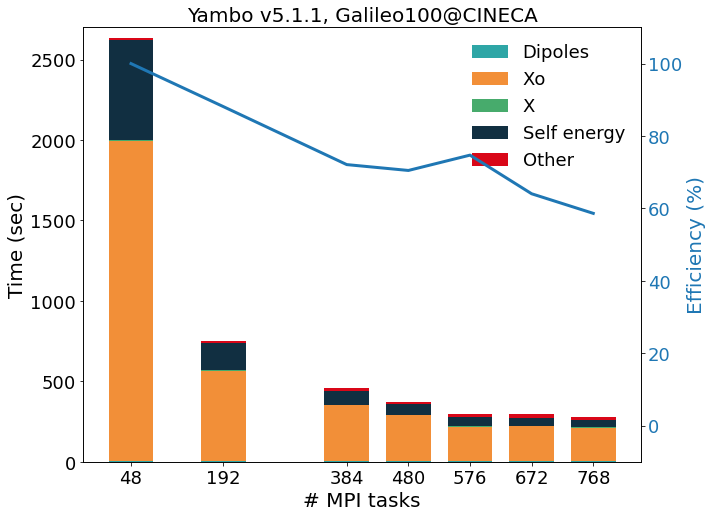

In [11]:
#myscaling=scaling[(scaling.mpi!=1360)]
build_scaling_plot(scaling=scaling, x_axis='mpi', x_label='# MPI tasks',
                   pile=pile, colors=colors, bar_width=70, efficiency=True,
                   legend_loc='upper right', title=r'Yambo v5.1.1, Galileo100@CINECA', 
                   file_name='yambo_scaling_cpu.png', y_lim=[0,2700])

In [12]:
def build_speedup_plot(scaling, label='yambo', title=None, y_lim=None, x_axis='mpi', file_name='speedup.png'):
    mylinestyle = {'marker':'o', 
                   'linewidth':3, 
                   'markersize':10, 
                   'markeredgewidth':3, 
                   'markerfacecolor':'white'}
    fig, ax = plt.subplots(figsize=(10, 7))
    if x_axis=='mpi':
        xlabel = 'MPI tasks'
    elif x_axis=='nodes':
        xlabel = 'Nodes'
    else:
        xlabel = x_axis
    ax.set_xlabel(xlabel,fontsize=20)
    ax.set_ylabel('Speedup',fontsize=20)
    ax.plot(scaling[x_axis], scaling['ideal'], color='gray', label='ideal', linestyle='dashed')
    ax.plot(scaling[x_axis], scaling['speedup'], 
             color='#2EA6A6', marker='.', markersize=15,
             label=label)
    if y_lim: ax.set_ylim(y_lim)
    ax.legend()
    ax.legend(fontsize='18',framealpha=0.0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
    plt.xticks(scaling[x_axis])
    if title: plt.title(title, fontsize=20)
    plt.savefig(file_name, bbox_inches='tight')

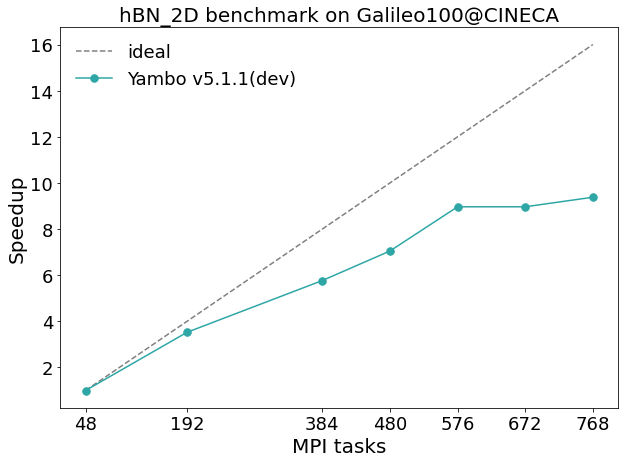

In [13]:
build_speedup_plot(scaling=scaling, title=r'hBN_2D benchmark on Galileo100@CINECA', label=r'Yambo v5.1.1(dev)', x_axis='mpi')